## Caso de estudio Autoencoders VAE

- Importaciones 

In [90]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from PIL import Image

### Procesamiento de datos.

- Dataset de CelebA: contiene ~200k imágenes de rostros.

In [91]:
IMG_DIR = "./datos_kaggle/img_align_celeba/img_align_celeba"
IMG_SIZE = 64

def load_images(img_dir, max_imgs=10000):
    files = sorted(os.listdir(img_dir))[:max_imgs]
    images = []
    for f in files:
        path = os.path.join(img_dir, f)
        img = Image.open(path).resize((IMG_SIZE, IMG_SIZE)).convert("RGB")
        images.append(np.array(img) / 255.0)
    return np.array(images, dtype=np.float32)

images = load_images(IMG_DIR, max_imgs=20000)

# Crear Dataset
BATCH_SIZE = 128
dataset = tf.data.Dataset.from_tensor_slices(images)
dataset = dataset.shuffle(buffer_size=1024).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print("Shape del dataset:", images.shape)


Shape del dataset: (20000, 64, 64, 3)


- Visualización de los datos 

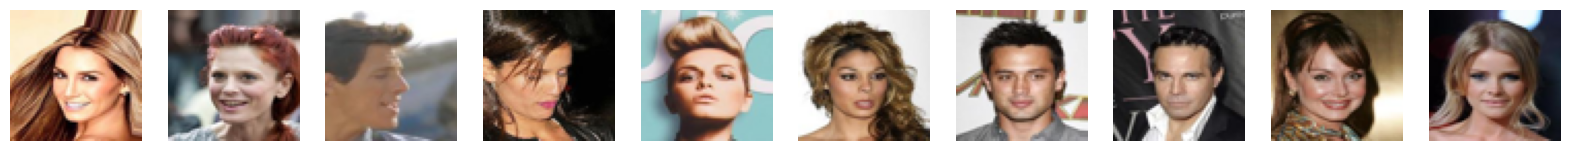

In [98]:
# 4. Mostrar algunas imágenes
def mostrar_imagenes(imgs, n=10):
    plt.figure(figsize=(20, 4))
    for i in range(n):
        ax = plt.subplot(1, n, i + 1)
        plt.imshow(imgs[i])
        plt.axis("off")
    plt.show()

mostrar_imagenes(images)

### Modelo VAE Convolucional

- Encoder

In [93]:
LATENT_DIM = 128

# --- ENCODER ---
def build_encoder():
    initializer = tf.keras.initializers.HeNormal()
    encoder_inputs = layers.Input(shape=(64, 64, 3))

    x = layers.Conv2D(32, 4, strides=2, padding='same', activation='relu', kernel_initializer=initializer)(encoder_inputs)  # 32x32
    x = layers.Conv2D(64, 4, strides=2, padding='same', activation='relu', kernel_initializer=initializer)(x)               # 16x16
    x = layers.Conv2D(128, 4, strides=2, padding='same', activation='relu', kernel_initializer=initializer)(x)              # 8x8
    x = layers.Conv2D(256, 4, strides=2, padding='same', activation='relu', kernel_initializer=initializer)(x)              # 4x4
    x = layers.Flatten()(x)

    z_mean = layers.Dense(LATENT_DIM, name="z_mean")(x)
    z_log_var = layers.Dense(LATENT_DIM, name="z_log_var")(x)

    return models.Model(encoder_inputs, [z_mean, z_log_var], name="encoder")

- Decoder

In [94]:
# --- DECODER ---
def build_decoder():
    initializer = tf.keras.initializers.HeNormal()
    latent_inputs = layers.Input(shape=(LATENT_DIM,))
    x = layers.Dense(4 * 4 * 512, activation='relu', kernel_initializer=initializer)(latent_inputs)
    x = layers.Reshape((4, 4, 512))(x)

    x = layers.Conv2DTranspose(256, 4, strides=2, padding='same', activation='relu', kernel_initializer=initializer)(x)  # 8x8
    x = layers.Conv2DTranspose(128, 4, strides=2, padding='same', activation='relu', kernel_initializer=initializer)(x)  # 16x16
    x = layers.Conv2DTranspose(64, 4, strides=2, padding='same', activation='relu', kernel_initializer=initializer)(x)   # 32x32
    x = layers.Conv2DTranspose(32, 4, strides=2, padding='same', activation='relu', kernel_initializer=initializer)(x)   # 64x64
    outputs = layers.Conv2DTranspose(3, 3, padding='same', activation='sigmoid')(x)

    return models.Model(latent_inputs, outputs, name="decoder")

- Modelo VAE

In [95]:
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.sampler = self.sampling

    def sampling(self, args):
        z_mean, z_log_var = args
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    def call(self, inputs):
        z_mean, z_log_var = self.encoder(inputs)
        z = self.sampler([z_mean, z_log_var])
        reconstruction = self.decoder(z)
        return reconstruction

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var = self.encoder(data)
            z = self.sampler([z_mean, z_log_var])
            reconstruction = self.decoder(z)

            reconstruction_loss = tf.reduce_mean(tf.square(data - reconstruction))
            kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        return {"loss": total_loss, "reconstruction_loss": reconstruction_loss, "kl_loss": kl_loss}




- Entrenamiento

In [97]:
# --- CALLBACKS ---
early_stop = tf.keras.callbacks.EarlyStopping(
    patience=5, 
    restore_best_weights=True,
    verbose=1
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    patience=3, 
    factor=0.5,
    verbose=1
)
# --- CREACIÓN Y ENTRENAMIENTO ---
encoder = build_encoder()
decoder = build_decoder()
vae = VAE(encoder, decoder)

vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3))

history = vae.fit(
    dataset,
    epochs=30,
    callbacks=[early_stop, reduce_lr]
)


Epoch 1/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 51s 306ms/step - kl_loss: 0.0027 - loss: 0.0850 - reconstruction_loss: 0.0823 - learning_rate: 0.0010
Epoch 2/30


c:\Users\Eduardo\Desktop\EntonoTensorflow\.venv\Lib\site-packages\keras\src\callbacks\early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: kl_loss,loss,reconstruction_loss
  current = self.get_monitor_value(logs)
c:\Users\Eduardo\Desktop\EntonoTensorflow\.venv\Lib\site-packages\keras\src\callbacks\callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: kl_loss,loss,reconstruction_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


157/157 ━━━━━━━━━━━━━━━━━━━━ 46s 292ms/step - kl_loss: 0.0041 - loss: 0.0742 - reconstruction_loss: 0.0701 - learning_rate: 0.0010
Epoch 3/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 47s 299ms/step - kl_loss: 0.0067 - loss: 0.0693 - reconstruction_loss: 0.0625 - learning_rate: 0.0010
Epoch 4/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 49s 312ms/step - kl_loss: 0.0070 - loss: 0.0690 - reconstruction_loss: 0.0619 - learning_rate: 0.0010
Epoch 5/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 47s 302ms/step - kl_loss: 0.0071 - loss: 0.0687 - reconstruction_loss: 0.0616 - learning_rate: 0.0010
Epoch 6/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 47s 300ms/step - kl_loss: 0.0072 - loss: 0.0688 - reconstruction_loss: 0.0616 - learning_rate: 0.0010
Epoch 7/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 48s 305ms/step - kl_loss: 0.0075 - loss: 0.0684 - reconstruction_loss: 0.0609 - learning_rate: 0.0010
Epoch 8/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 47s 302ms/step - kl_loss: 0.0076 - loss: 0.0682 - reconstruction_loss: 0.0606 - learning_rate: 0.0010
Epoch 9/30
157/15

### Visualización de Resultados

- Pérdida durante el entrenamiento

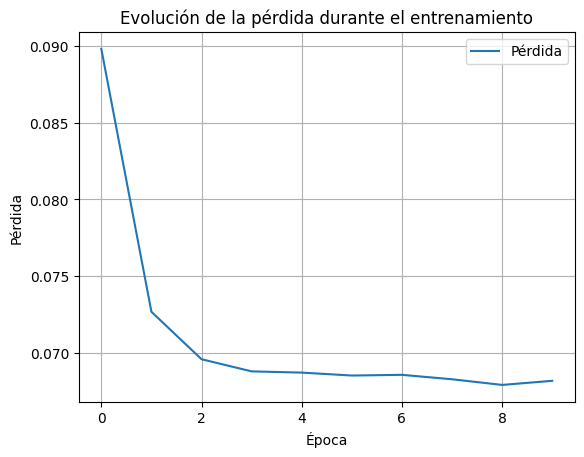

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history.history["loss"], label="Total Loss")
plt.plot(history.history["reconstruction_loss"], label="Reconstruction Loss")
plt.plot(history.history["kl_loss"], label="KL Divergence")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training Losses")
plt.grid(True)
plt.show()

- Generación de nuevas caras

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


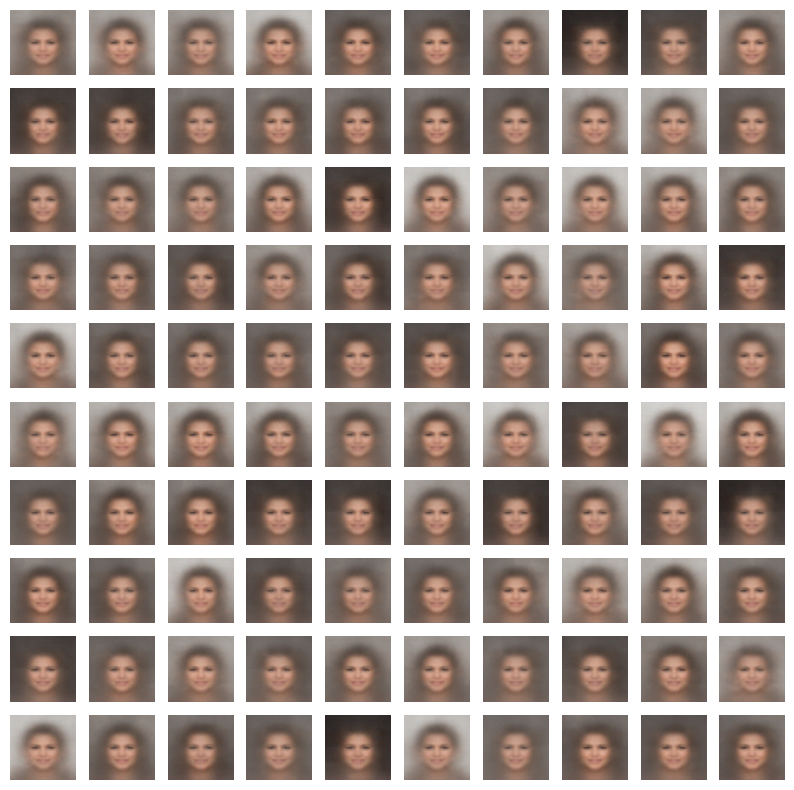

In [ ]:
def plot_latent_samples(decoder, n=10, latent_dim=64):
    fig, axs = plt.subplots(n, n, figsize=(10, 10))
    for i in range(n):
        for j in range(n):
            z_sample = np.random.normal(size=(1, latent_dim))
            x_decoded = decoder.predict(z_sample)
            axs[i, j].imshow(x_decoded[0])
            axs[i, j].axis("off")
    plt.tight_layout()
    plt.suptitle("Imágenes generadas por el VAE", fontsize=16)
    plt.show()

plot_latent_samples(decoder, n=10, latent_dim=64)


- Ejemplo de Visualización de Imagen Original vs Reconstruida

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


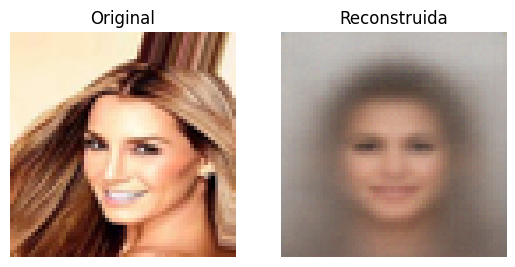

In [ ]:
test_img = images[0:1]
z_mean, z_log_var = encoder.predict(test_img)
z = Sampling()([z_mean, z_log_var])
recon = decoder.predict(z)

plt.subplot(1, 2, 1)
plt.imshow(test_img[0])
plt.title("Original")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(recon[0])
plt.title("Reconstruida")
plt.axis('off')
plt.show()